In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

In [15]:
def C_1(t, C0, Pe1, tau1):
    term_1 = C0 / 2 / np.sqrt(np.pi*Pe1 * (t/tau1))
    term_2 = np.exp(-1 * (1-(t/tau1))**2 / Pe1 / (t/tau1))        
    return term_1 * term_2

def C_LFR(t, C0, tau):
    C = C0 * tau**2 / 2 / t**3 
    return np.where(t < tau/2, 0, C)



C:\Users\jacob\AppData\Local\Temp\ipykernel_20364\1999247052.py:2: RuntimeWarning: divide by zero encountered in divide
  term_1 = C0 / 2 / np.sqrt(np.pi*Pe1 * (t/tau1))
C:\Users\jacob\AppData\Local\Temp\ipykernel_20364\1999247052.py:3: RuntimeWarning: divide by zero encountered in divide
  term_2 = np.exp(-1 * (1-(t/tau1))**2 / Pe1 / (t/tau1))
C:\Users\jacob\AppData\Local\Temp\ipykernel_20364\1999247052.py:4: RuntimeWarning: invalid value encountered in multiply
  return term_1 * term_2
C:\Users\jacob\AppData\Local\Temp\ipykernel_20364\1999247052.py:7: RuntimeWarning: divide by zero encountered in divide
  C = C0 * tau**2 / 2 / t**3


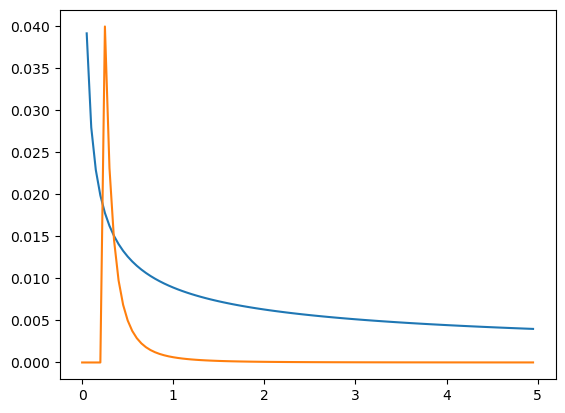

In [26]:
t_range = np.arange(0, 5, 0.05)

plt.figure()
plt.plot(t_range, C_1(t_range, 1, 1000, 1))
plt.plot(t_range, C_LFR(t_range, 5e-3, 0.5))
plt.show()



$$\frac{d(\rho V C)}{dt} = \dot{m}C_{LFR} - \dot{m}C$$

$$\frac{dC}{dt} = \frac{\dot{m}}{\rho V}C_{LFR} - \frac{\dot{m}}{\rho V}C$$

$$\frac{\dot{m}}{\rho V} = \frac{1}{\tau_{CSTR}}$$

$$\frac{dC}{dt} = \frac{C_{LFR}}{\tau_{CSTR}} - \frac{C}{\tau_{CSTR}}$$

$$\tau_{LFR1} = \frac{a*\rho V}{\dot{m}*\alpha} = \frac{a\tau}{\alpha}$$
$$\tau_{CSTR1} = \frac{b\tau}{\alpha}$$

$$\tau_{LFR2} = \frac{c\tau}{1 - \alpha}$$
$$\tau_{CSTR2} = \frac{d\tau}{1 - \alpha}$$

and

$$d = 1 - a - b - c$$

$$C_{LFR} = \frac{\tau_{LFR}^2}{2 t^3}C_0 \Delta t$$
$$\frac{dC}{dt} = \frac{C_{LFR}}{\tau_{CSTR}} - \frac{C}{\tau_{CSTR}}$$




$$\tau_{LFR1} = \frac{a*\rho V}{\dot{m}*\alpha} = \frac{a\tau}{\alpha}$$
$$\tau_{CSTR1} = \frac{b\tau}{\alpha}$$

$$\tau_{LFR2} = \frac{c\tau}{1 - \alpha}$$
$$\tau_{CSTR2} = \frac{d\tau}{1 - \alpha}$$

and

$$d = 1 - a - b - c$$





In [214]:
from scipy.integrate import solve_ivp
import numpy as np

def CLFR(tau_LFR, time, C0, delta_t):
    C = np.where(time < tau_LFR / 2, 0, (tau_LFR**2) / (2 * time**3) * C0 * delta_t)
    return C


def CSTR(time, C, tau_CSTR, tau_LFR, C0, delta_t):
    dCdt = (CLFR(tau_LFR, time, C0, delta_t) - C) / tau_CSTR
    return dCdt


def reactor_system(t, a, b, c, alpha):
    tau = 6.91888e-07 / 2.25 / 10**-6 # System residence time
    C0 = 1  # Initial concentration
    delta_t = 0.000355558 # Time step
    
    d = 1 - a - b - c  # Calculate d based on a, b, and c
    
    tau_LFR1 = a * tau / alpha
    tau_CSTR1 = b * tau / alpha
    tau_LFR2 = c * tau / (1 - alpha)
    tau_CSTR2 = d * tau / (1 - alpha)

    C1_args = (tau_CSTR1, tau_LFR1, C0, delta_t)
    C2_args = (tau_CSTR2, tau_LFR2, C0, delta_t)


    t_span = (t[0], t[-1])
    y0 = [0]

    C_final1 = solve_ivp(CSTR, t_span, y0, t_eval=t, args=C1_args)
    C_final2 = solve_ivp(CSTR, t_span, y0, t_eval=t, args=C2_args)


    C_final = alpha*C_final1.y[0] + (1-alpha)*C_final2.y[0]

    return C_final


C:\Users\jacob\AppData\Local\Temp\ipykernel_20364\3437029341.py:16: RuntimeWarning: overflow encountered in square
  return np.sum((mass_fraction[1:] - predictions) ** 2)
c:\Users\jacob\anaconda3\envs\transonic\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Global minimum found at: [0.48823002 0.02940686 0.04385155 0.85164057]


C:\Users\jacob\AppData\Local\Temp\ipykernel_20364\2647844371.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  C = np.where(time < tau_LFR / 2, 0, (tau_LFR**2) / (2 * time**3) * C0 * delta_t)


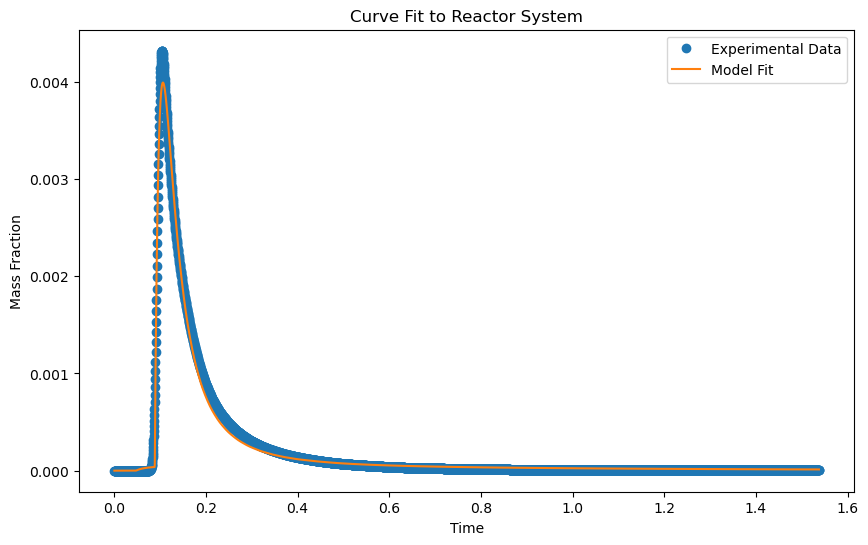

Optimized Parameters: [0.48823002 0.02940685 0.04385157 0.85164057]


In [221]:
import pandas as pd
from scipy.optimize import curve_fit, differential_evolution
import matplotlib.pyplot as plt

# Load the CSV file
data = pd.read_csv(r'C:\Users\jacob\OneDrive - University of Louisville\Projects\Dissertation\PhaseI\data_analysis\TRANSONIC\TRANSONIC\data\C_curves\sim173.csv')


# Extract time and mass_fraction from your data
time = data['time'].values
mass_fraction = data['mass_fraction'].values

def objective(params):
    a, b, c, alpha = params
    predictions = reactor_system(time[1:], a, b, c, alpha)
    return np.sum((mass_fraction[1:] - predictions) ** 2)

# Define bounds for each parameter (a, b, c, alpha)
eps = 1e-3
bounds = [(0, 1), (0, 1), (0, 1), (0, 1)]

# Use differential_evolution to find the best initial parameters
result = differential_evolution(objective, bounds, seed=420)

print("Global minimum found at:", result.x)


# Curve fitting
initial_guess = result.x  # Initial guesses for a, b, c, alpha
bounds = [(0, 0, 0, 0), (1, 1, 1, 1)]
params_opt, params_cov = curve_fit(reactor_system, data.time.iloc[1:].to_numpy(), data.mass_fraction.iloc[1:], p0=initial_guess, bounds=bounds)

# Generate predictions using the optimized parameters for the entire time range
predictions = reactor_system(time, *params_opt)

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(time, mass_fraction, 'o', label='Experimental Data')
plt.plot(time, predictions, '-', label='Model Fit')
# plt.plot(time[1:], reactor_system(time[1:], 0.83711451, 0.08231108, 0.58825223, 0.9686498))
plt.xlabel('Time')
plt.ylabel('Mass Fraction')
plt.title('Curve Fit to Reactor System')
plt.legend()
plt.show()

print("Optimized Parameters:", params_opt)


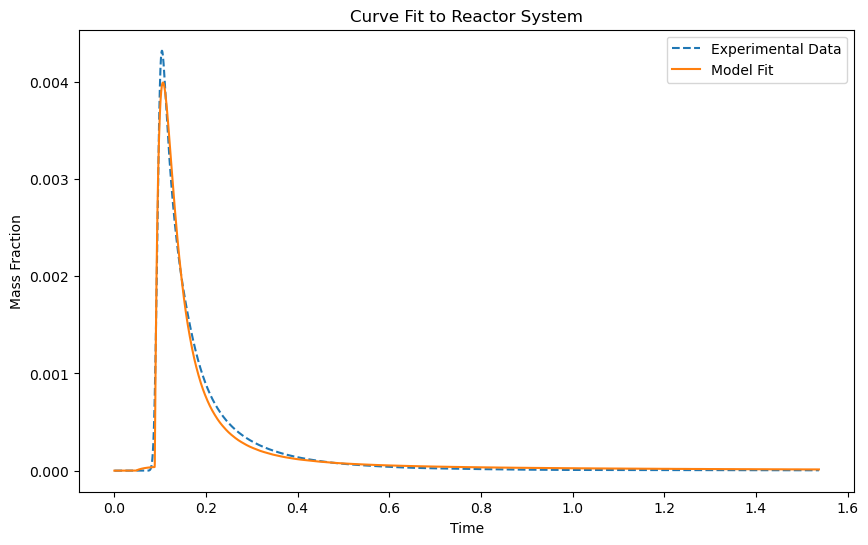

Optimized Parameters: [0.48823002 0.02940685 0.04385157 0.85164057]


In [222]:
# Visualization
plt.figure(figsize=(10, 6))
plt.plot(time, mass_fraction, '--', label='Experimental Data')
plt.plot(time, predictions, '-', label='Model Fit')
# plt.plot(time[1:], reactor_system(time[1:], 0.83711451, 0.08231108, 0.58825223, 0.9686498))
plt.xlabel('Time')
plt.ylabel('Mass Fraction')
plt.title('Curve Fit to Reactor System')
plt.legend()
plt.show()

print("Optimized Parameters:", params_opt)

c:\Users\jacob\OneDrive - University of Louisville\Projects\Dissertation\PhaseI\data_analysis\TRANSONIC\TRANSONIC\notebooks


C:\Users\jacob\AppData\Local\Temp\ipykernel_20364\2384865514.py:15: RuntimeWarning: divide by zero encountered in scalar divide
  return np.where(t < tau_LFR / 2, 0, tau_LFR**2 / (2 * t**3) * C0 * delta_t)


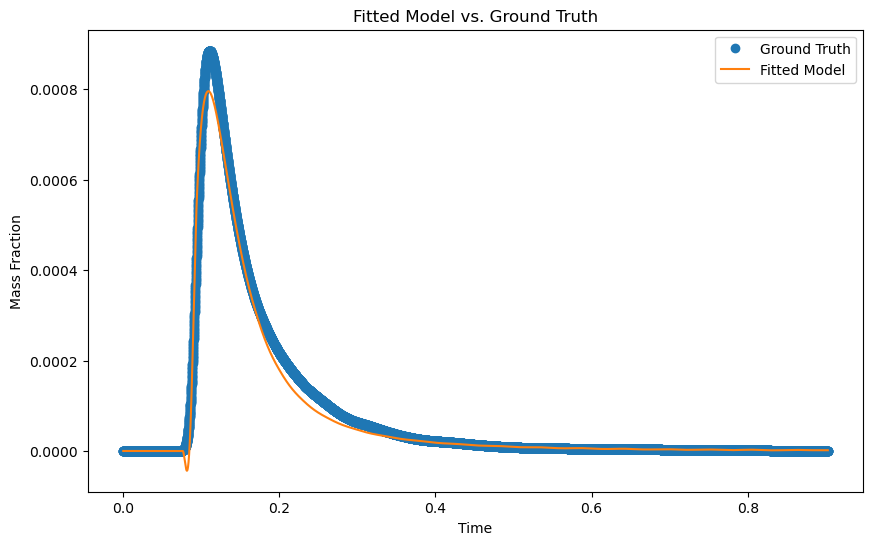

Optimized Parameters (a, b): [0.90825501 0.09174503]


In [248]:
import pandas as pd
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt

# Constants
tau = 6.77009e-07 / 3.75 / 10**-6  # System residence time
C0 = 1  # Initial concentration
delta_t = 7.68006e-05  # Time step
sim = 257

def CLFR(tau_LFR, t):
    """Calculate concentration out of the LFR, adjusted for dead zone effect."""
    return np.where(t < tau_LFR / 2, 0, tau_LFR**2 / (2 * t**3) * C0 * delta_t)

def CSTR(t, C, tau_CSTR, tau_LFR):
    """Differential equation for the CSTR."""
    dCdt = (CLFR(tau_LFR, t) - C) / tau_CSTR
    return dCdt

def reactor_system(t, a, b):
    """Integrate the full system: LFR followed by CSTR with corrected initial condition."""
    tau_LFR = a * tau
    tau_CSTR = b * tau
    
    # Solve the CSTR, setting initial concentration to 0
    sol = solve_ivp(CSTR, [0, t[-1]], [0], t_eval=t, args=(tau_CSTR, tau_LFR))
    return sol.y[0]

# Load the ground truth data from the CSV file

data = pd.read_csv(f'..\\data\\C_curves\\sim{sim}.csv')  # Adjust the path to your CSV file
t_observed = data['time'].values
y_observed = data['mass_fraction'].values

def objective(params):
    """Objective function for optimization."""
    a, b = params
    y_predicted = reactor_system(t_observed, a, b)
    return np.sum((y_observed - y_predicted)**2)

def objective_with_penalty(params):
    a, b = params
    penalty = 0
    if a + b > 1:  # Adding a penalty if a + b exceeds 1
        penalty = 1000 * (a + b - 1)**2  # Example penalty term; adjust as needed
    y_predicted = reactor_system(t_observed, a, b)
    ssd = np.sum((y_observed - y_predicted)**2)
    return ssd + penalty

# Bounds for a and b
bounds = [(0, 1), (0, 1)]

# Run differential evolution
result = differential_evolution(objective_with_penalty, bounds, polish=True)

# Generating predictions using the optimized parameters for plotting
y_predicted = reactor_system(t_observed, *result.x)

# Plotting the fitted model against the ground truth
plt.figure(figsize=(10, 6))
plt.plot(t_observed, y_observed, 'o', label='Ground Truth')
plt.plot(t_observed, y_predicted, '-', label='Fitted Model')
plt.xlabel('Time')
plt.ylabel('Mass Fraction')
plt.title('Fitted Model vs. Ground Truth')
plt.legend()
plt.show()

print("Optimized Parameters (a, b):", result.x)


C:\Users\jacob\AppData\Local\Temp\ipykernel_20364\1934741458.py:14: RuntimeWarning: divide by zero encountered in divide
  return np.where(t < tau_LFR / 2, 0, tau_LFR**2 / (2 * t**3) * C0 * delta_t)
C:\Users\jacob\AppData\Local\Temp\ipykernel_20364\1934741458.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  return np.where(t < tau_LFR / 2, 0, tau_LFR**2 / (2 * t**3) * C0 * delta_t)


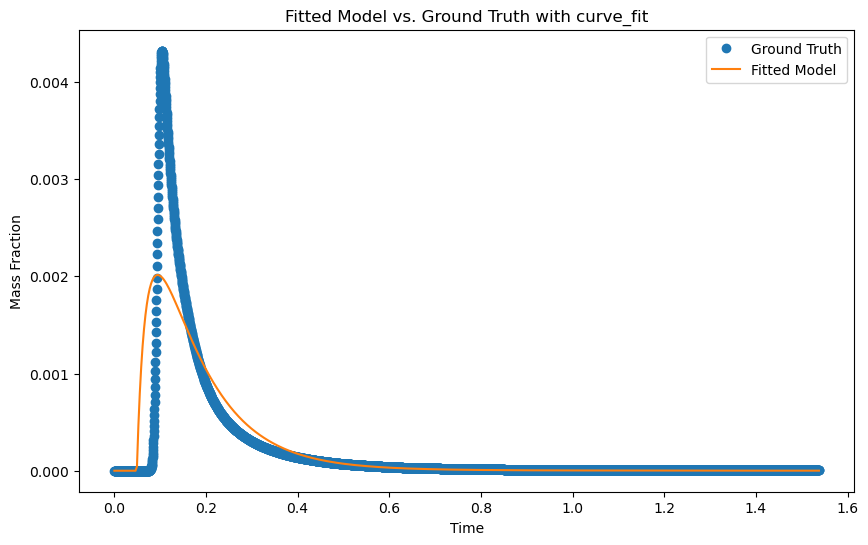

Optimized Parameters (a, b): [0.31776557 0.30663231]


In [242]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import solve_ivp
import pandas as pd

# Constants
tau = 6.91888e-07 / 2.25 / 10**-6  # System residence time
C0 = 1  # Initial concentration
delta_t = 0.000355558  # Time step

def CLFR(tau_LFR, t):
    """Calculate concentration out of the LFR."""
    return np.where(t < tau_LFR / 2, 0, tau_LFR**2 / (2 * t**3) * C0 * delta_t)

def reactor_system_model(t, a, b):
    """Model function adapted for curve_fit."""
    # Calculate tau for LFR and CSTR
    tau_LFR = a * tau
    tau_CSTR = b * tau
    
    # Initially assuming C_LFR_out as constant for simplicity
    C_LFR_out = CLFR(tau_LFR, t)
    
    # Solve the CSTR from t=0 to t=end using solve_ivp
    sol = solve_ivp(lambda t, C: CSTR(t, C, tau_CSTR, tau_LFR), [0, t[-1]], [0], t_eval=t)
    return sol.y.ravel()

# Load the ground truth data
data = pd.read_csv('../data/sim173.csv')
t_observed = data['time'].values
y_observed = data['mass_fraction'].values

# Curve fitting
initial_guess = [0.25, 0.25]  # Initial guesses for a and b
params_opt, params_cov = curve_fit(reactor_system_model, t_observed, y_observed, p0=initial_guess)

# Generating predictions using the optimized parameters for plotting
t_fine = np.linspace(min(t_observed), max(t_observed), 500)
y_predicted = reactor_system_model(t_fine, *params_opt)

# Plotting the fitted model against the ground truth
plt.figure(figsize=(10, 6))
plt.plot(t_observed, y_observed, 'o', label='Ground Truth')
plt.plot(t_fine, y_predicted, '-', label='Fitted Model')
plt.xlabel('Time')
plt.ylabel('Mass Fraction')
plt.title('Fitted Model vs. Ground Truth with curve_fit')
plt.legend()
plt.show()

print("Optimized Parameters (a, b):", params_opt)


In [2]:
import numpy as np

cum = [1, 2, 3]

print(np.append(cum, 0))
print(np.append(0, cum))

[1 2 3 0]
[0 1 2 3]
